## Introduction

I'll start with an understatement: the last year and a half has been *weird*. For those of us in big cities, there has been a highly tangible change in the ebb and flow of day-to-day life. Among those changes is how we interact with restaurants. At least in NYC, this has often meant ordering in food for delivery rather than making the trip to dine-in. While many New Yorkers used this as a means of supporting beloved local business, it also brought attention to the idea of the [ghost kitchen](https://en.wikipedia.org/wiki/Ghost_kitchen).

The basic premise of my project and its problem statement rests with this concept: what if I were to convert my own home kitchen into a ghost kitchen? At a base level, what kind of setup might I need to achieve this from the comfort of my own home? 

In order to address this, I designed a model to parameterize and simulate the act of running a pizza kitchen.

## Model

The core loop of the model involves generating a number of orders for each hour of the workday utilizing a Poisson distribution. Once those numbers are established, a uniform distribution is used to randomize and assign the actual time of the calls within the given hour. Assuming independence among calls, this allows us to simulate the randomness of customer calls in a reasonable way.

There are a few basic assumptions/limitations that are made in the model:

* There is only one current offering: a plain cheese pizza.
* Food preparation is done prior to "operational" hours.
* One order is equal to one pizza.
* Delivery is not a part of the equation as it will be outsourced to a delivery service.
* I'm assuming $\lambda = 12$ per hour - the number of pizzas producible in sequence within an hour given my real-world setup.

As orders come in, they form a queue and, if capacity is available, enter the oven and bake for the given bake time. It should be noted that the actual pizza recipe and baking time are completely real - this is my current working recipe after several years in the amateur pizza-making game.

While the assumptions/limitations above simplify the system a fair degree, this feels appropriate as iteratively introducing complexity to a model based on experimentation, results and informed investigation is the approach we have been exposed to through the run of this course. 

I will provide my own thoughts on how to proceed with this simulation on a go-forward basis at the end. For now, I'll import, visualize, and discuss the results of my model.

In [1]:
from json import loads
from pandas import concat, DataFrame, merge, read_csv
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

results1 = read_csv('basic_results.csv')
results1['turnaround'] = results1.finish_time - results1.order_time

In [2]:
def standardize(
    title=None,
    xlabel=None, ylabel=None,
    xticks=None, yticks=None
):
    """
    Creates a lineplot optimized for PowerPoint based on the information found
    at https://www.pythonforthelab.com/blog/python-tip-ready-publish-matplotlib-figures/.
    
    data: a pandas DataFrame object
    x: the desired x-axis variable/column name as a string
    y: the desired y-axis variable/column name as a string
    marker: matplotlib marker to be used for lineplot; defaults to 'o'.
    linestyle: matplotlib linestyle to be used for lineplot; defaults to '--'.
    fontsize: size of font for labels, will increase by 2 for axes and title.
    """

    if title:
        plt.title(title, fontsize = 18)
    
    if xlabel:
        plt.xlabel(xlabel, fontsize = 16)
    
    if ylabel:
        plt.ylabel(ylabel, fontsize = 16)
    
    if xticks:
        plt.xticks(xticks, fontsize = 14)
    
    if yticks:
        plt.yticks(yticks, fontsize = 14)

## Initial Findings

One of the main areas of concern is the ability to prep for delivery in a timely fashion. By running one-thousand simulations, I can rely on the law of large numbers to assume the results reasonably approximate the expected outcome(s).

I measured this by calculating the turnaround time between the initial call and the time the pizza came out of the oven.

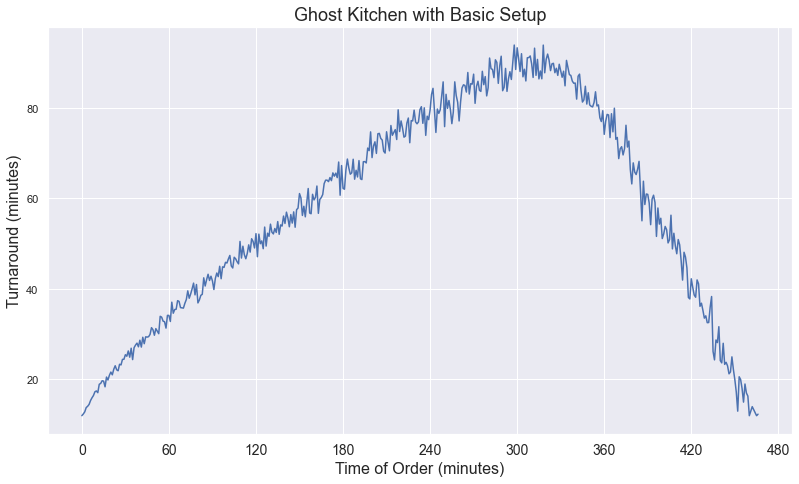

In [3]:
sns.set(rc={'figure.figsize':(13.33, 7.5)})

sns.lineplot(data=results1, x='order_time', y='turnaround', ci=None)
standardize(
    title='Ghost Kitchen with Basic Setup', 
    xlabel='Time of Order (minutes)', ylabel='Turnaround (minutes)',
    xticks=[x for x in range(0, 481, 60)]
)

These results are not the best! We have reasonable turnaround times for delivery up until the end of the first hour. At that point, the queue seems to become overwhelmed and it takes several hours to recover. In essence, we're only operating at a reasonable capacity in our first and last hour of the day. 

Ideally, no order should wait more than 30 minutes before heading out the door for delivery.

# Capacity Sweep

I ran the experiment again sweeping through a series of oven capacities between 2 and 20. This should help identify the optimal oven capacity assuming everything else about the model remains true.

In [4]:
results2 = read_csv('cs_results.csv')
results2['turnaround'] = results2.finish_time - results2.order_time
results2['capacity'] = 'capacity=' + (results2.iteration + 2).astype(str)

Summarizing the results shows us something important - there is no real benefit to going to a greater `capacity` than `7` or `8`. Returns on investment here diminish sharply after a `capacity` of `4`.

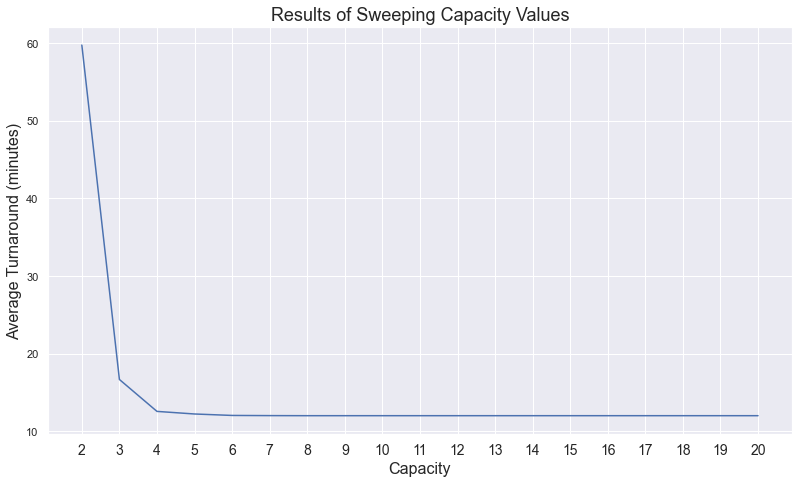

In [41]:
capacity_results = results2.groupby(['iteration', 'capacity'], as_index=False)['turnaround'].agg(['min', 'max', 'mean'])
capacity_results.sort_values(by='iteration', inplace=True)
capacity_results.reset_index(inplace=True)

sns.lineplot(x=capacity_results.iteration + 2, y='mean', data=capacity_results)
standardize(
    title='Results of Sweeping Capacity Values', 
    ylabel='Average Turnaround (minutes)', 
    xlabel='Capacity', 
    xticks=[x for x in range(2, 21)]
)

Knowing this, I can now run the simulation with a (partially) optimized capacity of `4`. Certainly, this is not the full-scale optimization of `8`, but at the same time my goal isn't to open a full-fledged pizza parlour. We're going for a much smaller-scale operation based out of my own home.

In [6]:
results3 = read_csv('opt_results.csv')
results3['turnaround'] = results3.finish_time - results3.order_time

Having made this change, we can see the results visualized below. This is a significant difference - by adding two more resource slots, we've made it so that in 1,000 iterations our process time has never exceeded 14 minutes. This is massive improvement from before where we had to delay deliveries more than 40 minutes most of the workday.

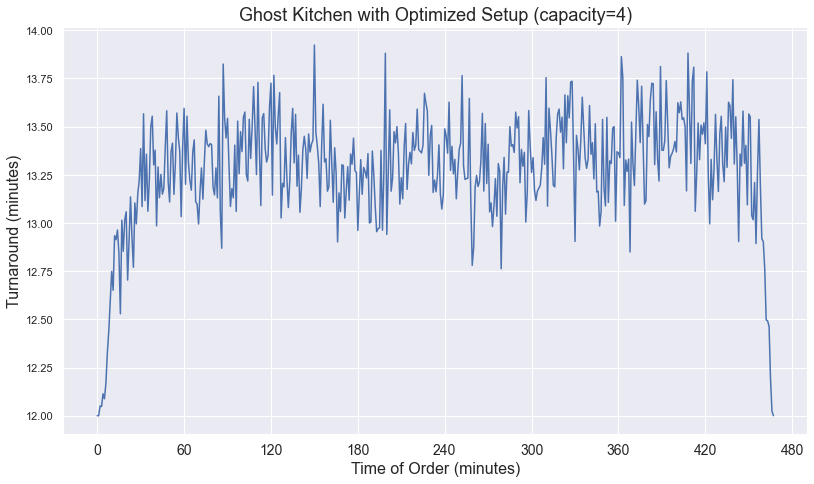

In [7]:
sns.set(rc={'figure.figsize':(13.33, 7.5)})

sns.lineplot(data=results3, x='order_time', y='turnaround', ci=None)
standardize(
    title='Ghost Kitchen with Optimized Setup (capacity=4)', 
    xlabel='Time of Order (minutes)', ylabel='Turnaround (minutes)',
    xticks=[x for x in range(0, 481, 60)]
)

# Inventory Estimate

Operationally, things seem doable. The question that remains for me, before any deeper analysis involving costs, pricing, etc., would be what I would need to have on hand to meet the simulated demand. 

In other words, how much olive oil, flour, etc. will I need to have around to create the simulated volume of pizzas.

In [8]:
recipes = DataFrame([loads(recipe) for recipe in results3.recipe.str.replace("'", '"')])
recipes = concat([results3[['iteration', 'order']], recipes], axis=1)

In [9]:
grp_rec = recipes.groupby('iteration', as_index=False).agg('sum')
grp_rec.agg('mean')

iteration     499.50000
order        4685.27100
flour         670.61400
salt           16.28634
yeast           6.70614
water         455.05950
olive_oil      11.97525
sauce         574.81200
cheese        574.81200
dtype: float64

Based on this output, we can see the average accumulation of materials for a single day of operation. While I had initially thought looking at costs would be an easy next move I'm no longer sure on seeing this output. For one, the expected quantity of flour required for just a day is 670 ounces! As shown below, the sheer volume of output is also impressive considering the limited capacity model I chose - I could easily expect an average of 100 or so orders on a daily basis. Were I to charge \\$1 a slice, like the popular pizzeria style found throughout the city, we could expect to earn $500+ daily.

Text(0.5, 0, 'Number of Orders')

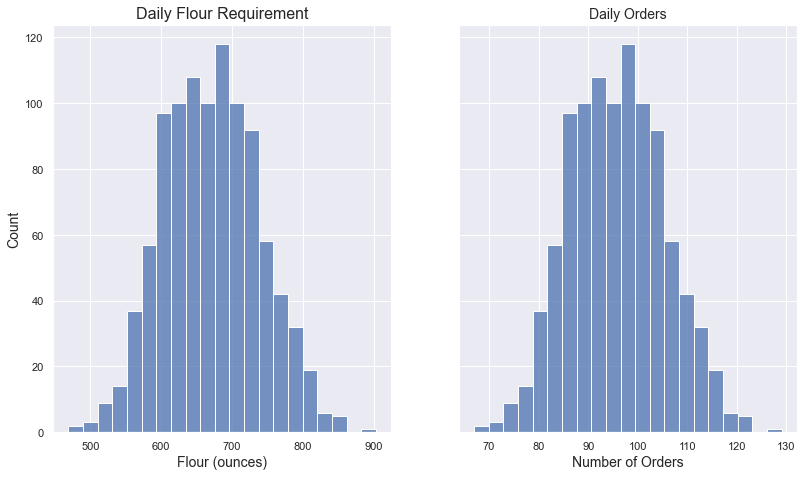

In [21]:
fig, ax = plt.subplots(1, 2, sharey=True)

sns.histplot(x='flour', data=grp_rec, ax=ax[0])
sns.histplot(x=results3.groupby('iteration')['order'].agg('count'), ax=ax[1])

ax[0].set_title('Daily Flour Requirement', fontsize=16)
ax[0].set_xlabel('Flour (ounces)', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)

ax[1].set_title('Daily Orders', fontsize=14)
ax[1].set_xlabel('Number of Orders', fontsize=14)

# Conclusions

At least based on this simulation, the notion of running a a ghost kitchen out of a small/home kitchen is not completely unreasonable. Because $\lambda$ here is a rough estimate, we can't know for certain that these results reflect reality. However, they give us a sense of what things would look like at a particular $\lambda$ value, which assuming demand does not initially start there means that there would be plenty of room for growth as the customer base grows.

My initial suspicion was that oven capacity would be the limiting factor for me, however, on simulating the process I'm actually much more concerned with supply storage. If a single day may range from roughly 500-1,000 ounces of flour, extrapolating that to a single week is a staggering supply. That alone makes it an unreasonable pursuit, rather than oven capacity, which could be reasonably achieved through counter-top peripherals.

Unreasonable as I might find this in my current home setting, what's interesting about all this is that it doesn't seem *that bad*. Given proper storage space and more time spent with the model to simulate operational costs, a business like this could be lucrative. 